# Autoencoders + Image Classifier Model

In this notebook, we explore combining an autoencoder network together with a classifier network using the CIFAR-10 image data set.

The autoencoder network is trained to reproduce the input images, while the classifier network takes the latent variables of the autoencoder as inputs, and classifies the image.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.utils import class_weight

try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow_addons
    import tensorflow_addons as tfa

# Attempt connecting to the GPU. If not, connect to the CPU.
try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

AUTO = tf.data.experimental.AUTOTUNE

Found GPU at: /device:GPU:0


# Data Preparation

Use the Cifar-10 dataset.

### Cifar10 Categories
0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck.

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [2]:
def load_cifar10_data(grayscale = False):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    if grayscale == True:
        X_train = tf.image.rgb_to_grayscale(X_train).numpy()
        X_test = tf.image.rgb_to_grayscale(X_test).numpy()
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [3]:
# Define constants related to data.

IMAGE_SHAPE = [32, 32]
cat_to_num = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

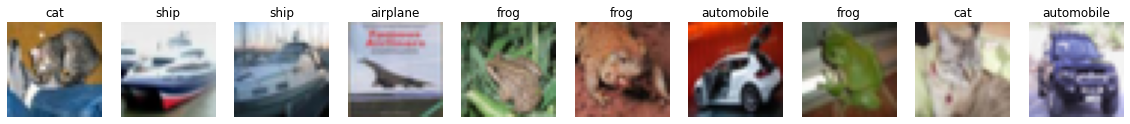

In [4]:
plt.figure(figsize = (20, 3))
for index in range(10):
    plt.subplot(1, 10, index+1)
    plt.title(cat_to_num[y_test[index][0]])
    plt.imshow(X_test[index].squeeze())
    plt.axis("off")
plt.show()

## Image Augmentation

Image augmentation is useful in forcing the model to generalize to new images. We implement several custom made image augmentation functions.

In [5]:
@tf.function
def random_flip_image(image):
    # Randomly flips an image left-right.
    r = np.random.random()
    if r <= 0.5:
        return tf.image.flip_left_right(image)
    else:
        return image

@tf.function
def random_brightness(rgb_image, max_delta = 0.1):
    # Randomly increase or decrease rgb image brightness.
    # Input SHOULD BE an RGB image [0, 255].
    return tf.image.random_brightness(rgb_image, max_delta = max_delta)

@tf.function
def random_contrast(rgb_image, lower = 0.9, upper = 1.1):
    # Randomly increase or decrease rgb image contrast.
    # Input SHOULD BE an RGB image [0, 255].
    return tf.image.random_contrast(rgb_image, lower = lower, upper = upper)

@tf.function
def random_hue(rgb_image, max_delta = 0.01):
    # Randomly increase or decrease rgb image hue.
    # Input SHOULD BE an RGB image [0, 255].
    return tf.image.random_hue(rgb_image, max_delta = max_delta)

@tf.function
def random_saturation(rgb_image, lower = 0.9, upper = 1.1):
    # Randomly increase or decrease rgb image hue.
    # Input SHOULD BE an RGB image [0, 255].
    return tf.image.random_saturation(image = rgb_image, lower = lower, upper = upper, seed = None)

@tf.function
def gaussian_noise(rgb_image, mean = 0, stddev = 1):
    # Adds Gaussian noise to an RGB image.
    # Input MUST BE an RGB image [0, 255].
    # tf.random.normal outputs float32 values. Cast them to uint8 values.
    # uint8 values have the the range [0, 255]. This means that overflow values
    # should be clipped by default.
    noise = tf.random.normal(tf.shape(rgb_image), mean = mean, stddev = stddev)
    return tf.cast(tf.cast(rgb_image, tf.dtypes.float32) + noise, tf.dtypes.uint8)

@tf.function
def image_augmentation(image):
    # Wrapper function which calls all image augmentation functions.
    # Image SHOULD be an RGB image [0, 255].
    #image = random_flip_image(image)
    image = random_brightness(image)
    image = random_hue(image)
    image = random_saturation(image)
    image = random_contrast(image)
    #image = gaussian_noise(image, stddev = 8)
    return image

## Make Training Data

Use `tf.data` to create the data pipeline into the neural network.

As we will train the autoencoder and classifier simultaneously, our `tf.data` pipeline will take as inputs the RGB image, and output the RGB image (for the autoencoder) and the image label (for the classifier).


In [6]:
# Use class weighting to account for imbalanced classes.

def get_class_weights(y):
    return class_weight.compute_class_weight("balanced", classes = np.unique(y.squeeze()), y = y.squeeze())

def make_classifier_data(X, y, batch_size = 32, encode_y = True, shuffle = False, augment_image = False, shuffle_buffer = 2**16):
    if encode_y == True:
        y = tf.keras.utils.to_categorical(y)

    # Input data (RGB images) for the model.
    if augment_image == True:
        # Use image augmentation to generalize model.
        # To-do: fix the image augmentation functionality!
        inputs = tf.data.Dataset.from_tensor_slices({"encoder_input": image_augmentation(X)})
    else:
        inputs = tf.data.Dataset.from_tensor_slices({"encoder_input": X})

    outputs = tf.data.Dataset.from_tensor_slices({"categorical_output": y})
    tf_data = tf.data.Dataset.zip((inputs, outputs))
    
    if shuffle == True:
        tf_data = tf_data.shuffle(shuffle_buffer)
        
    return tf_data.batch(batch_size)

def make_autoencoder_classifier_data(X, y, batch_size = 32, encode_y = True, shuffle = False, augment_image = False, shuffle_buffer = 2**16):
    # One hot encoding of the target variable.
    if encode_y == True:
        y = tf.keras.utils.to_categorical(y)
 
    # Input data (RGB images) for the model.
    if augment_image == True:
        # Use image augmentation to generalize model.
        # To-do: fix the image augmentation functionality!
        inputs = tf.data.Dataset.from_tensor_slices({"encoder_input": image_augmentation(X)})
    else:
        inputs = tf.data.Dataset.from_tensor_slices({"encoder_input": X})

    # Outputs (decoded RGB images, categorical classification) from the model.
    outputs = tf.data.Dataset.from_tensor_slices({"rgb_output": X, "categorical_output": y})

    tf_data = tf.data.Dataset.zip((inputs, outputs))

    # Use sample weights to account for the imbalanced classification data. 
    #if categorical_weights == True:
    #    sample_weights = tf.tensordot(y, tf.cast(class_weights, tf.dtypes.float32), axes = 1)
    #    sample_weights = tf.data.Dataset.from_tensor_slices({"categorical_output": sample_weights})
    #    tf_data = tf.data.Dataset.zip((inputs, outputs, sample_weights))
    #else:
    #    tf_data = tf.data.Dataset.zip((inputs, outputs))
    
    if shuffle == True:
        tf_data = tf_data.shuffle(shuffle_buffer)
        
    return tf_data.batch(batch_size)

In [7]:
batch_size = 32

class_train_data = make_classifier_data(X_train, y_train, batch_size = batch_size, 
                                        encode_y = True, shuffle = True, augment_image = False)
class_test_data = make_classifier_data(X_test, y_test, batch_size = batch_size, 
                                        encode_y = True, shuffle = True, augment_image = False)

auto_train_data = make_autoencoder_classifier_data(X_train, y_train, batch_size = batch_size, 
                                                   encode_y = True, shuffle = True, augment_image = False)
auto_test_data = make_autoencoder_classifier_data(X_test, y_test, batch_size = batch_size, 
                                                  encode_y = True, shuffle = False, augment_image = False)

print(class_train_data.element_spec)
print(class_test_data.element_spec)
print(auto_train_data.element_spec)
print(auto_test_data.element_spec)

({'encoder_input': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)}, {'categorical_output': TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)})
({'encoder_input': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)}, {'categorical_output': TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)})
({'encoder_input': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)}, {'rgb_output': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), 'categorical_output': TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)})
({'encoder_input': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)}, {'rgb_output': TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), 'categorical_output': TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)})


## Autoencoders and Image Classification 

There are several methods to use autoencoders in image classification problems. The most direct method is to first train an autoencoder, and the use the encoder portion of the autoencoder as the input to some classification network. Another method is to train an autoencoder simultaneously with a classifier network.

For this implementation we train an autoencoder together with a classifier network due to the lack of computational resources to train several neural networks.

We keep both networks extremely simple again due to the lack of computational resources to train more complex networks.

In [8]:
# Conv2D Layer.
def conv2d_layer(X, filters = 32, use_batch_normalization = False, use_dropout = False, dropout_rate = 0.5):
    X = tf.keras.layers.Conv2D(filters, kernel_size = 3, activation = "relu", 
                               padding = "same", strides = 2, name = "encoder_{}".format(filters))(X)
    if use_batch_normalization == True:
        X = tf.keras.layers.BatchNormalization()(X)
    if use_dropout == True:
        X = tf.keras.layers.Dropout(dropout_rate)(X)
    return X

# CNN Encoder. Encodes a 3 layer RGB image to some latent space.
def cnn_encoder(inputs, use_batch_normalization = False, use_dropout = False):
    # Rescale the inputs from [0, 255] to [0, 1].
    X = tf.keras.layers.Rescaling(1.0 / 255, name = "encoder_rescaling")(inputs)
    X = conv2d_layer(X, filters = 64, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    X = conv2d_layer(X, filters = 32, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    X = conv2d_layer(X, filters = 16, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    return X

def conv2d_transpose_layer(X, filters = 32, use_batch_normalization = False, use_dropout = False, dropout_rate = 0.5):
    X = tf.keras.layers.Conv2DTranspose(filters, kernel_size = 3, strides = 2, activation = "relu", 
                                        padding = "same", name = "decoder_{}".format(filters))(X)
    if use_batch_normalization == True:
        X = tf.keras.layers.BatchNormalization()(X) # BatchNormalization causes NaNs in certain versions of TF.
    if use_dropout == True:
        X = tf.keras.layers.Dropout(0.5)(X)                             
    return X

# CNN Decoder. Decodes the latent space back to 3 layer RGB images.
def cnn_decoder(inputs, use_batch_normalization = False, use_dropout = False):
    X = conv2d_transpose_layer(inputs, 16, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    X = conv2d_transpose_layer(X, 32, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    X = conv2d_transpose_layer(X, 64, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    # Prepare images for output using this convolution layer to create a 3 layer tensor.
    X = tf.keras.layers.Conv2D(3, kernel_size = (3, 3), activation = "sigmoid", padding = "same", name = "rgb_pre_output")(X)
    # Rescale the inputs from [0, 1] to [0, 255].
    X = tf.keras.layers.Rescaling(255, name = "rgb_output")(X)
    return X

# Dense Classifier. Classifies images based on the latent space outputs from the encoder.
def dense_classifier(inputs, N_classes = 10, use_dropout = False):
    X = tf.keras.layers.Flatten(name = "class_flatten")(inputs)
    X = tf.keras.layers.Dense(128, activation = "relu", name = "class_dense_128")(X)
    if use_dropout == True:
        X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(N_classes, activation = "softmax", name = "categorical_output")(X)
    return X

# CNN classifier.
def cnn_classifier(input_shape = [*IMAGE_SHAPE, 3], use_batch_normalization = False, use_dropout = False):
    images = tf.keras.layers.Input(input_shape, name = "encoder_input")
    encoded = cnn_encoder(images, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    classed = dense_classifier(encoded, use_dropout = use_dropout)
    return tf.keras.Model(inputs = images, outputs = classed)

# Autoencoder classifier.
def autoencoder_classifier(input_shape = [*IMAGE_SHAPE, 3], use_batch_normalization = False, use_dropout = False):
    images = tf.keras.layers.Input(input_shape, name = "encoder_input")
    encoded = cnn_encoder(images, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    decoded = cnn_decoder(encoded, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    classed = dense_classifier(encoded, use_dropout = use_dropout)
    return tf.keras.Model(inputs = images, outputs = [decoded, classed])

# For categorical inference.
def encoded_classifier(input_shape = [*IMAGE_SHAPE, 3], use_batch_normalization = False, use_dropout = False):
    images = tf.keras.layers.Input(input_shape, name = "encoder_input")
    encoded = cnn_encoder(images, use_batch_normalization = use_batch_normalization, use_dropout = use_dropout)
    classed = dense_classifier(encoded, use_dropout = use_dropout)
    return tf.keras.Model(inputs = images, outputs = classed)

In [9]:
def make_model(device_name = DEVICE_NAME, use_auto_encoder = False):
    with tf.device(device_name):
        if use_auto_encoder == False:
            model = cnn_classifier(use_batch_normalization = True, use_dropout = True)
            model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                          loss = {"categorical_output": tf.keras.losses.CategoricalCrossentropy()},
                          metrics = {"categorical_output": tf.keras.metrics.CategoricalAccuracy()})
        else:
            model = autoencoder_classifier(use_batch_normalization = False, use_dropout = False)
            model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                          loss = {"rgb_output": tf.keras.losses.MeanSquaredError(), 
                                  "categorical_output" : tf.keras.losses.CategoricalCrossentropy()},
                          metrics = {"categorical_output": tf.keras.metrics.CategoricalAccuracy()})
    return model

cnn_class = make_model(use_auto_encoder = False)
auto_class = make_model(use_auto_encoder = True)

## Training the Neural Network

Training a neural network, especially if the network is deep and complex and insufficient high performance computing resources are available, is an exercise in patience.

The final performance of the model is dependent on the randomized initial model parameters, and in order to optimize for the best model we usually train multiple models simultaneously, each starting from a different set of randomized initial model parameters.

In [10]:
def plot_train_history(history):
    plt.figure(figsize = (15, 5))
    plt.title("Training History")
    plt.subplot(3, 1, 1)
    plt.plot(range(1, 1+len(history.history["loss"])), history.history["loss"])
    plt.plot(range(1, 1+len(history.history["val_loss"])), history.history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.subplot(3, 1, 2)
    plt.plot(range(1, 1+len(history.history["rgb_output_loss"])), history.history["rgb_output_loss"])
    plt.plot(range(1, 1+len(history.history["val_rgb_output_loss"])), history.history["val_rgb_output_loss"])
    plt.legend(["rgb_output_loss", "val_rgb_output_loss"])
    plt.subplot(3, 1, 3)
    plt.plot(range(1, 1+len(history.history["categorical_output_loss"])), history.history["categorical_output_loss"])
    plt.plot(range(1, 1+len(history.history["val_categorical_output_loss"])), history.history["val_categorical_output_loss"])
    plt.legend(["categorical_output_loss", "val_categorical_output_loss"])
    plt.xlabel("Epochs")
    plt.show()

### Classifier Training

In [11]:
cnn_history = cnn_class.fit(class_train_data, epochs = 40, validation_data = class_test_data, verbose = 0)

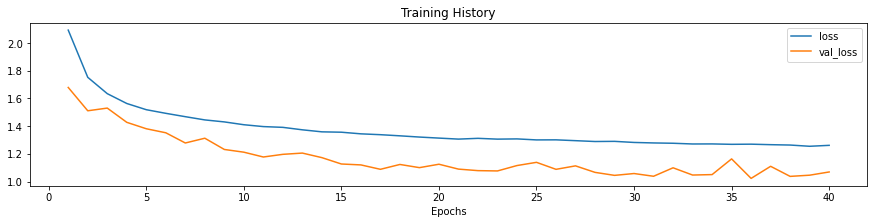

In [12]:
plt.figure(figsize = [15, 3])
plt.title("Training History")
plt.plot(range(1, 1+len(cnn_history.history["loss"])), cnn_history.history["loss"])
plt.plot(range(1, 1+len(cnn_history.history["val_loss"])), cnn_history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel("Epochs")
plt.show()

### Autoencoder + Classifier Training

In [13]:
auto_class_history = auto_class.fit(auto_train_data, epochs = 40, validation_data = auto_test_data, verbose = 0)

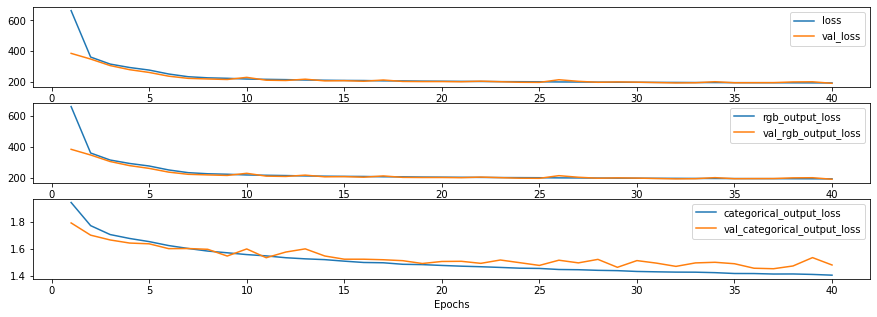

In [14]:
plot_train_history(auto_class_history)

## Visualize the Model's Predictions

We use a simple function to visualize the autoencoder's output, as well as the classifier's predictions.

In [15]:
def visualize_prediction(model, X, y, i = 0):
    y_pred = model(tf.expand_dims(X[i], 0))

    img_pred = tf.cast(y_pred[0], tf.dtypes.uint8).numpy()
    class_pred = y_pred[1]

    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Decoded image, predicted as: {}.".format(cat_to_num[np.argmax(class_pred)]))
    plt.imshow(img_pred.squeeze())
    plt.subplot(1, 2, 2)
    plt.title("Original image of a: {}.".format(cat_to_num[y_test[i][0]]))
    plt.imshow(X[i].squeeze())
    plt.show()

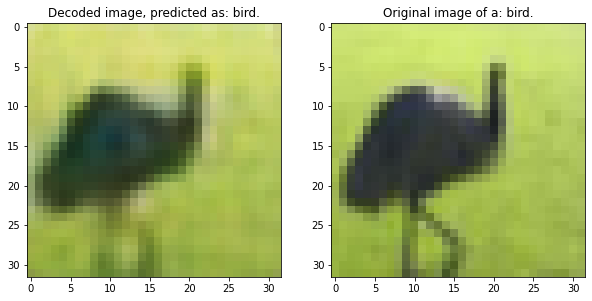

In [16]:
visualize_prediction(auto_class, X_test, y_test, 123)

In [17]:
# To-do:
# Create functionality for handling the inference model, such as handling the 
# transferring of the weights from the trained model to the inference model.

# The inference model should ideally handle pure classification, and not have 
# any form of decoder output.

## Other Comments

Due to the very shallow nature of the model, while the autoencoder appears to work relatively well, classification performance is not that great. Using a deeper model together with well designed regularization layers within the network, as well as the appropriate loss functions such as the Focal loss or the Tversky loss will improve the model's performance to imbalanced datasets.

We also need to improve on the metrics used to evaluate the model. Categorical accuracy is not a good metric for imbalanced data.